In [1]:
import os
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import missingno as msno

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.svm import SVC

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
import matplotlib
%matplotlib inline

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'22', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
axis_font = {'fontname':'Arial', 'size':'20'}

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
root_dir = ''
csv_file_path = os.path.join(root_dir, 'generated_data.csv')
raw_data = pd.read_csv(csv_file_path).set_index('time_stamp')
# raw_data['date'] = pd.to_datetime(raw_data['timestamp'])
# raw_data.drop(columns=['timestamp'], inplace=True)
raw_data

shutdown_id       RPM  sec_from_start  is_abnormal
time_stamp                                                              
Jan 07 2021 13:15:22            0  1.007726               0            0
Jan 07 2021 13:15:23            0  0.977986               1            0
Jan 07 2021 13:15:24            0  0.867193               2            0
Jan 07 2021 13:15:25            0  0.952333               3            0
Jan 07 2021 13:15:26            0  0.954875               4            0
...                           ...       ...             ...          ...
Dec 27 2020 23:35:25          999  0.052713             495            1
Dec 27 2020 23:35:26          999  0.060816             496            1
Dec 27 2020 23:35:27          999  0.145114             497            1
Dec 27 2020 23:35:28          999  0.144954             498            1
Dec 27 2020 23:35:29          999  0.132312             499            1

[500000 rows x 4 columns]

<AxesSubplot:xlabel='sec_from_start', ylabel='RPM'>

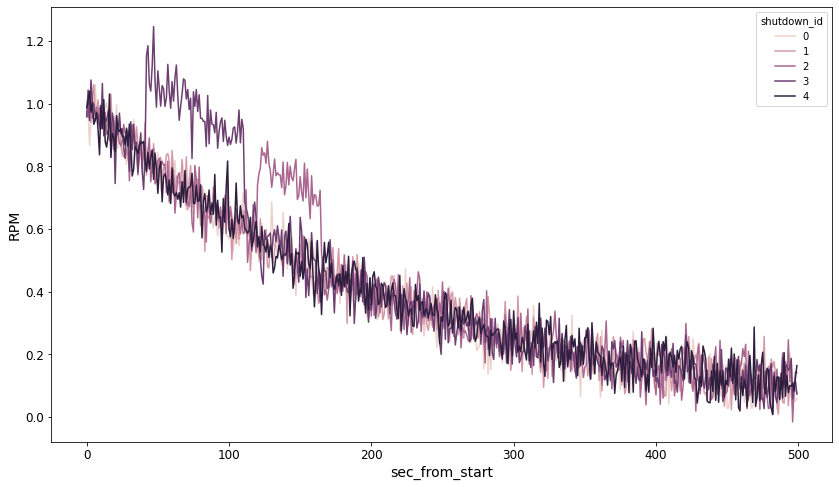

In [4]:
plot_data = raw_data.loc[raw_data['shutdown_id'] < 5]

fig = plt.figure()
fig.set_size_inches(14, 8)
sns.lineplot(data=plot_data, x="sec_from_start", y="RPM", hue="shutdown_id")

In [5]:
sns.set_theme(style="darkgrid")

def plot_2_signals(x, y, y_pred, inds, outlier_ind):
    fig = plt.figure()
    fig.set_size_inches(8, 8)
    plt.grid(True)

    filter_ind = (outlier_ind > inds[0]) * (outlier_ind < inds[1])
    zoomed_out_ind = outlier_ind[filter_ind]

    plt.plot(x[inds[0]:inds[1]], y[inds[0]:inds[1]], label='orig', color='g', linestyle="--", linewidth=1)
    plt.plot(x[inds[0]:inds[1]], y_pred[inds[0]:inds[1]], label='pred', color='b', linestyle="-", linewidth=2)

    plt.plot(x['sec_from_start'][zoomed_out_ind].values,
             y['RPM'][zoomed_out_ind].values,
             label="Outside 1StD", color='r',
             linestyle="None", marker="o", linewidth=2)


    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 15})

    plt.xlabel('index', **axis_font)
    plt.ylabel("Signals magnitude", **axis_font)
    plt.title('Detrending', **title_font)
    plt.show()

In [6]:
process_id = 1
break_data = raw_data.loc[raw_data['shutdown_id'] == process_id]
y = break_data[['RPM']]
x = break_data[['sec_from_start']]

In [7]:
averaged = raw_data[['sec_from_start', 'RPM']].groupby('sec_from_start', as_index=False).mean()
averaged.head()

sec_from_start       RPM
0               0  1.001217
1               1  0.993809
2               2  0.992103
3               3  0.987477
4               4  0.983183

<AxesSubplot:xlabel='sec_from_start', ylabel='RPM'>

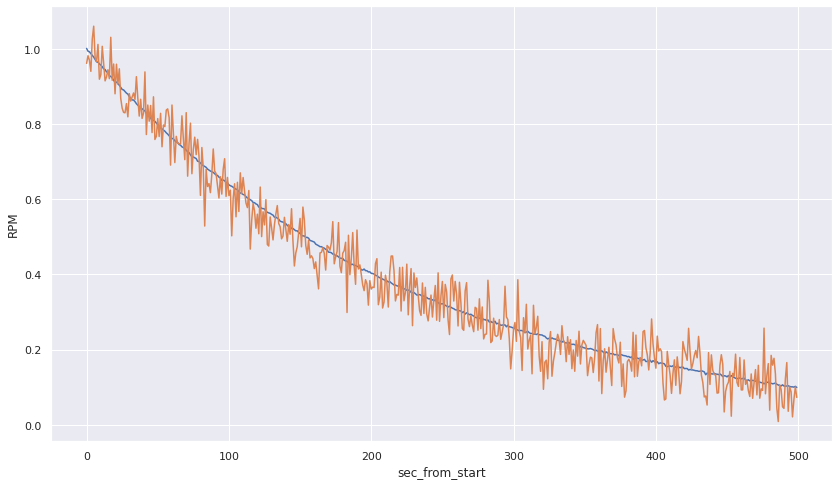

In [8]:
fig = plt.figure()
fig.set_size_inches(14, 8)
sns.lineplot(data=averaged, x="sec_from_start", y="RPM")
sns.lineplot(data=break_data, x="sec_from_start", y="RPM")

<AxesSubplot:xlabel='sec_from_start'>

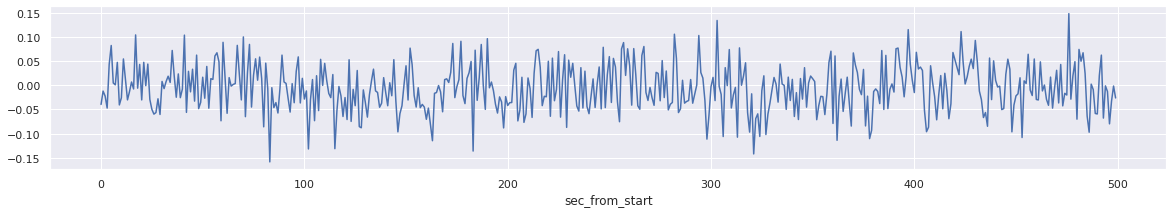

In [9]:
y_val = break_data['RPM'].values - averaged['RPM'].values
fig = plt.figure()
fig.set_size_inches(20, 3)
plt.grid(True)
sns.lineplot(data=averaged, x='sec_from_start', y=y_val)

In [10]:
def get_features(sig):

    features = {
        'mean' : sig.values.mean(),
        'var' : sig.values.var(),
        'std' : sig.values.std(),

        'thr_0_15' : (sig > 0.15).sum(),
        'thr_0_2' : (sig > 0.2).sum(),
        'thr_0_25' : (sig > 0.25).sum(),
        'thr_0_3' : (sig > 0.3).sum(),
        'thr_0_35' : (sig > 0.35).sum(),
        'thr_0_4' : (sig > 0.4).sum(),
        'thr_0_45' : (sig > 0.45).sum(),

        'roll_mean_10_mean' : sig.rolling(window=10).mean().mean(),
        'roll_mean_10_std' : sig.rolling(window=10).mean().std(),
        'roll_std_10_mean' : sig.rolling(window=10).std().mean(),
        'roll_std_10_std' : sig.rolling(window=10).std().std(),

        'roll_mean_20_mean' :sig.rolling(window=20).mean().mean(),
        'roll_mean_20_std' : sig.rolling(window=20).mean().std(),
        'roll_std_20_mean' :sig.rolling(window=20).std().mean(),
        'roll_std_20_std' : sig.rolling(window=20).std().std(),
    }
    return features

In [11]:
def plot_outlier(detrended, ind):
    fig = plt.figure()
    fig.set_size_inches(8, 8)
    plt.grid(True)

    x = detrended.index.values
    y = detrended['RPM'].values

    plt.plot(x, y, label="Detrended", color='g', linestyle="--", linewidth=2)
    plt.plot(x[ind[0]], y[ind[0]], label="Outside 1StD", color='r', linestyle="None", marker="o", linewidth=2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 15})

    plt.xlabel('index', **axis_font)
    plt.ylabel("Signals magnitude", **axis_font)
    plt.title('Detrending', **title_font)
    plt.show()

def pred_averaged_df(averaged_df):
    return averaged_df['RPM'].values

def pred_fft(signal, dtu=1, fq_thr=0.05):
    orig_signal = signal['RPM'].values
    fq = np.fft.fft(orig_signal)
    w = np.fft.fftfreq(len(orig_signal), dtu)
    fq[(abs(w) > fq_thr)] = 0
    # fq[(abs(w) == 0)] = 0

    reconst = np.fft.ifft(fq)
    reconst = np.real(reconst)

    n = 40  # replace first values
    reconst[:n] = orig_signal[:n].mean()
    reconst[-n:] = orig_signal[-n:].mean()
    return reconst

import statsmodels.api as sm
def pred_sarimax(signal):
    model = sm.tsa.statespace.SARIMAX(signal['RPM'], order=(5,2,0))
    model = model.fit(disp=-1)
    pred = model.predict(start=signal.index[0], dynamic=False)
    n = 3  # replace first values
    pred[:n] = signal['RPM'][:n]
    return pred

def pred_arima(signal):
    model = ARIMA(signal['RPM'], order=(5, 2, 0))
    results = model.fit(disp=-1)
    # print(results.summary())

    predicted = results.predict(start=signal.index[1],
                                end=signal.index[-2])
    pred = predicted.values
    pred = np.insert(pred, 0, pred[0], axis=0)
    return pred

def pred_polynomical(signal):
    x = signal.index.values.reshape(-1, 1)
    y =  signal[['RPM']].values

    model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                      ('linear', LinearRegression(fit_intercept=False))])
    model = model.fit(x, y)

    y_pred = model.predict(x)
    return y_pred.flatten()

In [12]:
def get_signal_by_id(process_id):
    data = raw_data.loc[raw_data['shutdown_id'] == process_id]
    data = data[['RPM', 'sec_from_start']]
    data.reset_index(inplace=True, drop=True)
    return data

new_cols = ['pred_poly', 'pred_sarimax', 'pred_fft', 'pred_avg_df', 'pred_ma']
for col in new_cols:
    raw_data[col] = np.NaN

for sid in raw_data['shutdown_id'].unique():
    signal = get_signal_by_id(sid)
    mask = raw_data['shutdown_id'] == sid

    raw_data.loc[mask, 'pred_poly'] = pred_polynomical(signal)
    raw_data.loc[mask, 'pred_sarimax'] = pred_sarimax(signal)
    raw_data.loc[mask, 'pred_fft'] = pred_fft(signal)
    raw_data.loc[mask, 'pred_avg_df'] = pred_averaged_df(averaged)
    raw_data.loc[mask, 'pred_ma'] = signal['RPM'].rolling(window=10).mean().fillna(method='bfill').values

raw_data.to_csv('data_with_recalc.csv', index=True)

/home/vpad/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/vpad/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/vpad/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='time_stamp'>

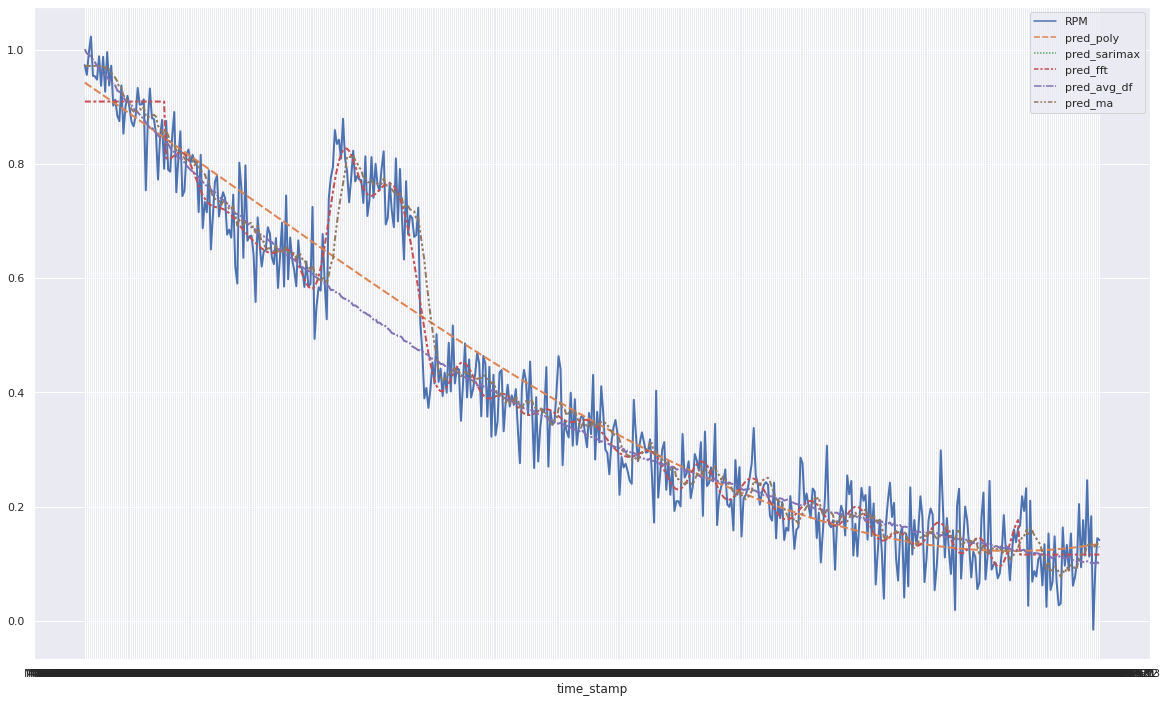

In [13]:
plot_data = raw_data[raw_data['shutdown_id'] == 2]

cols = plot_data.columns
plot_data = plot_data[cols[~cols.isin(['shutdown_id', 'sec_from_start', 'is_abnormal'])]]

fig = plt.figure()
fig.set_size_inches(20, 12)
plt.grid(True)
# sns.lineplot(x='secs_from_start', y='RPM', data=plot_data)

sns.lineplot(data=plot_data, linewidth=2)

In [14]:
feat_df = pd.DataFrame()
target_col = 'pred_avg_df'

for sid in raw_data['shutdown_id'].unique():
    data_sid = raw_data[raw_data['shutdown_id'] == sid]
    signal = data_sid[target_col] - data_sid['RPM']

    feats = get_features(signal)
    for k, v in feats.items():
        feat_df.loc[sid, k] = v


feat_df.to_csv('feat_' + target_col + '.csv', index=True)

In [15]:
raw_data

shutdown_id       RPM  sec_from_start  is_abnormal  \
time_stamp                                                                 
Jan 07 2021 13:15:22            0  1.007726               0            0   
Jan 07 2021 13:15:23            0  0.977986               1            0   
Jan 07 2021 13:15:24            0  0.867193               2            0   
Jan 07 2021 13:15:25            0  0.952333               3            0   
Jan 07 2021 13:15:26            0  0.954875               4            0   
...                           ...       ...             ...          ...   
Dec 27 2020 23:35:25          999  0.052713             495            1   
Dec 27 2020 23:35:26          999  0.060816             496            1   
Dec 27 2020 23:35:27          999  0.145114             497            1   
Dec 27 2020 23:35:28          999  0.144954             498            1   
Dec 27 2020 23:35:29          999  0.132312             499            1   

                      pred_poly  pred_sarimax  pred_fft  pred_avg_df   pred_ma  
time_stamp                                                                      
Jan 07 2021 13:15:22   0.991260           NaN  0.914769     1.001217  0.971741  
Jan 07 2021 13:15:23   0.986952           NaN  0.914769     0.993809  0.971741  
Jan 07 2021 13:15:24   0.982659           NaN  0.914769     0.992103  0.971741  
Jan 07 2021 13:15:25   0.978382           NaN  0.914769     0.987477  0.971741  
Jan 07 2021 13:15:26   0.974119           NaN  0.914769     0.983183  0.971741  
...                         ...           ...       ...          ...       ...  
Dec 27 2020 23:35:25   0.017147           NaN  0.113446     0.101313  0.096167  
Dec 27 2020 23:35:26   0.013487           NaN  0.113446     0.101258  0.100000  
Dec 27 2020 23:35:27   0.009799           NaN  0.113446     0.100493  0.097912  
Dec 27 2020 23:35:28   0.006083           NaN  0.113446     0.102529  0.107300  
Dec 27 2020 23:35:29   0.002339           NaN  0.113446     0.099553  0.105192  

[500000 rows x 9 columns]

In [16]:
feat_df.describe()

mean          var          std     thr_0_15      thr_0_2  \
count  1.000000e+03  1000.000000  1000.000000  1000.000000  1000.000000   
mean  -2.300937e-17     0.003939     0.059438     1.003000     0.023000   
std    1.244422e-02     0.003171     0.020163     0.979771     0.149978   
min   -4.102098e-02     0.002003     0.044759     0.000000     0.000000   
25%    2.520044e-03     0.002436     0.049359     0.000000     0.000000   
50%    4.958195e-03     0.002555     0.050545     1.000000     0.000000   
75%    6.904192e-03     0.002741     0.052351     2.000000     0.000000   
max    1.284360e-02     0.017154     0.130973     5.000000     1.000000   

       thr_0_25  thr_0_3  thr_0_35  thr_0_4  thr_0_45  roll_mean_10_mean  \
count    1000.0   1000.0    1000.0   1000.0    1000.0       1.000000e+03   
mean        0.0      0.0       0.0      0.0       0.0      -1.723621e-17   
std         0.0      0.0       0.0      0.0       0.0       1.265437e-02   
min         0.0      0.0       0.0      0.0       0.0      -4.201024e-02   
25%         0.0      0.0       0.0      0.0       0.0       2.515683e-03   
50%         0.0      0.0       0.0      0.0       0.0       5.122895e-03   
75%         0.0      0.0       0.0      0.0       0.0       6.945019e-03   
max         0.0      0.0       0.0      0.0       0.0       1.312424e-02   

       roll_mean_10_std  roll_std_10_mean  roll_std_10_std  roll_mean_20_mean  \
count       1000.000000       1000.000000      1000.000000       1.000000e+03   
mean           0.028964          0.049279         0.013145      -1.690315e-17   
std            0.027760          0.001997         0.003702       1.288002e-02   
min            0.011982          0.044237         0.008621      -4.317253e-02   
25%            0.015193          0.047937         0.011038       2.597804e-03   
50%            0.016208          0.049059         0.011799       5.188665e-03   
75%            0.017766          0.050456         0.012953       7.093154e-03   
max            0.119419          0.057558         0.027159       1.303408e-02   

       roll_mean_20_std  roll_std_20_mean  roll_std_20_std  
count       1000.000000       1000.000000      1000.000000  
mean           0.024548          0.050563         0.010793  
std            0.028313          0.002883         0.006353  
min            0.007495          0.044792         0.005237  
25%            0.010407          0.048677         0.007426  
50%            0.011469          0.049894         0.008146  
75%            0.013098          0.051605         0.009245  
max            0.115607          0.061538         0.033701

In [17]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

X = feat_df.values
scaler = StandardScaler()
scaler.fit(X)
X_normalized = scaler.transform(X)

clust = KMeans(n_clusters=3, random_state=0).fit(X_normalized)
# clust = DBSCAN(eps=0.3, min_samples=5).fit(X)
feat_df['cluster'] = clust.labels_

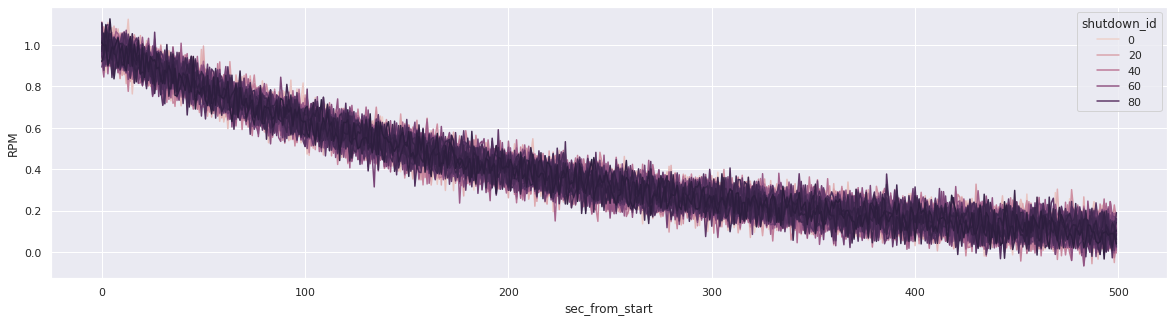

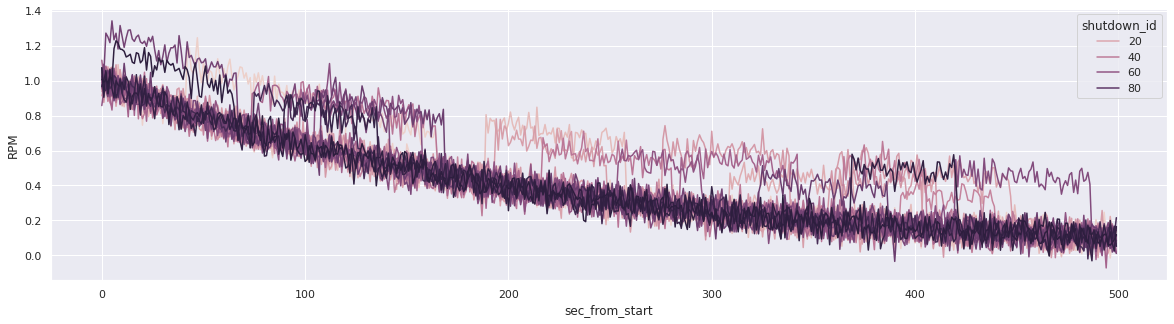

In [21]:
plottable = raw_data[raw_data['shutdown_id'] < 100]

for cl_val in feat_df['cluster'].unique():

    sids = feat_df[feat_df['cluster'] == cl_val].index
    plot_data = plottable[plottable['shutdown_id'].isin(sids)]

    fig = plt.figure()
    fig.set_size_inches(20, 5)
    sns.lineplot(data=plot_data, x="sec_from_start", y="RPM", hue="shutdown_id")


In [19]:
y_true = raw_data[['is_abnormal', 'shutdown_id']].groupby('shutdown_id').max().values.flatten()
y_pred = feat_df['cluster'].values
y_pred[y_pred == [2]] = 0

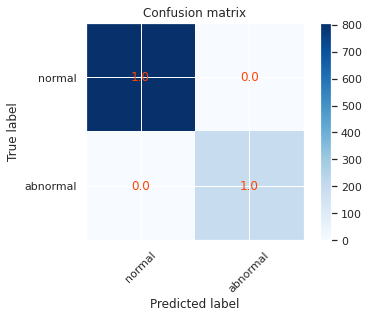

In [22]:
from sklearn.metrics import (confusion_matrix, roc_curve, auc,
                             average_precision_score, precision_recall_curve,
                             balanced_accuracy_score, roc_auc_score,
                             precision_score, recall_score)
import itertools

def get_conf_mat_plot(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = 'orangered'
        plt.text(j, i, cm[i, j], horizontalalignment="center", verticalalignment="center", color=color)

    # plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)


cm = confusion_matrix(y_true, y_pred)
get_conf_mat_plot(cm, ['normal', 'abnormal'])
